## The Real Estate Market in Germany

The purpose of the given project is the analysis of the market data and the elaboration of an  general overview of the german rental real estate market with the focus on the city of Köln. We will analyze parsed data about the rental real estate offers to determine the price range, the factors of influence and the locations that may significantly influence the rental price.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
plt.style.use('seaborn')

# Importing CSV file
df = pd.read_csv('C:/Users/Sinch/Desktop/ProjectRE/immo_data.csv')
df = df.copy()

In [2]:
# Renaming the columns and dropping the columns I won't use
df.rename(columns={'regio1': 'Land', 'serviceCharge': 'Nebenkosten', 'heatingType': 'Heizung',
                   'telekomTvOffer': 'TV_incl', 'newlyConst': 'New_const', 'balcony':'Balkon',
                   'pricetrend': 'Preis Entwicklung', 'totalRent': 'Warmmiete', 'yearConstructed' : 'Bau_jahr',
                   'noParkSpaces': 'Park_spaces_num', 'firingTypes': 'Heizungsart', 'hasKitchen': 'Einbauküche',
                   'cellar': 'Keller', 'baseRent': 'Kaltmiete', 'livingSpace': 'Living_space',
                   'condition': 'Zustand', 'interiorQual': 'Int_quality', 'petsAllowed': 'Haustiere',
                   'lift': 'Lift', 'typeOfFlat': 'Wohnungstyp', 'noRooms': 'Zimmer_num',
                   'thermalChar':'Energieeffizienzklasse', 'floor': 'Stock', 'numberOfFloors': 'Stöcke_num',
                   'garden': 'Garten', 'regio2': 'Stadt','regio3': 'Stadt_Teil', 'description': 'Description',
                   'facilities': 'Facilities', 'heatingCosts': 'Heizungskosten', 'lastRefurbish': 'Sanierungsjahr'
                  }, inplace=True)

df = df.drop(columns=['telekomHybridUploadSpeed', 'picturecount', 'telekomUploadSpeed',
                      'geo_bln', 'yearConstructedRange', 'houseNumber', 'geo_krs',
                      'street', 'streetPlain', 'baseRentRange', 'geo_plz','noRoomsRange', 
                      'livingSpaceRange', 'energyEfficiencyClass','electricityBasePrice',
                      'electricityKwhPrice', 'Sanierungsjahr', 'Park_spaces_num', 'Haustiere',
                      'TV_incl'])

### 1. The analysis of the Nordrhein Westfalen Region

Because I live in the NRW region and I am familiar with this region I will focus my analysis on this region.

In [3]:
# Selecting NRW
df = df[df["Land"] == "Nordrhein_Westfalen"]

In [4]:
# These 3 columns represent the TotalRent, BaseRent and HeatingCosts
df_miete = df.loc[:, ["Warmmiete", "Kaltmiete", "Heizungskosten"]]
df_miete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62863 entries, 0 to 268848
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Warmmiete       50759 non-null  float64
 1   Kaltmiete       62863 non-null  float64
 2   Heizungskosten  23618 non-null  float64
dtypes: float64(3)
memory usage: 1.9 MB


Normally we should use the TotalRent column as Price column but because we have a lot of missing values in the HeatingCosts column it is impossible to determine the TotalRent without loosing the data.

In [5]:
# let's see what we have there
df.Kaltmiete.describe()

count     62863.000000
mean        601.637195
std         610.535788
min           0.000000
25%         371.000000
50%         490.000000
75%         700.000000
max      120000.000000
Name: Kaltmiete, dtype: float64

In [6]:
# Filtering the unrealistic values
df = df[(df['Kaltmiete'] > 100) & (df['Kaltmiete'] < 6000)]
df = df[(df['Living_space'] > 10) & (df['Living_space'] < 460)]

In [7]:
df['Price_m2'] = (df['Kaltmiete'] / df['Living_space']).round()

In [8]:
df.Price_m2

0          7.0
9          5.0
13         8.0
14        11.0
18         5.0
          ... 
268828     5.0
268830     7.0
268837     8.0
268844     7.0
268848    12.0
Name: Price_m2, Length: 62814, dtype: float64

In [9]:
df_city = df[df["Stadt"].str.contains(r"[Kk]reis") == False]
df_pv = df_city.pivot_table(values='Kaltmiete', index='Stadt', aggfunc=(np.mean)).reset_index()
df_pv = df_pv.sort_values(by=['Kaltmiete'], ascending=False)
df_pv['Kaltmiete'] = df_pv['Kaltmiete'].astype(int)

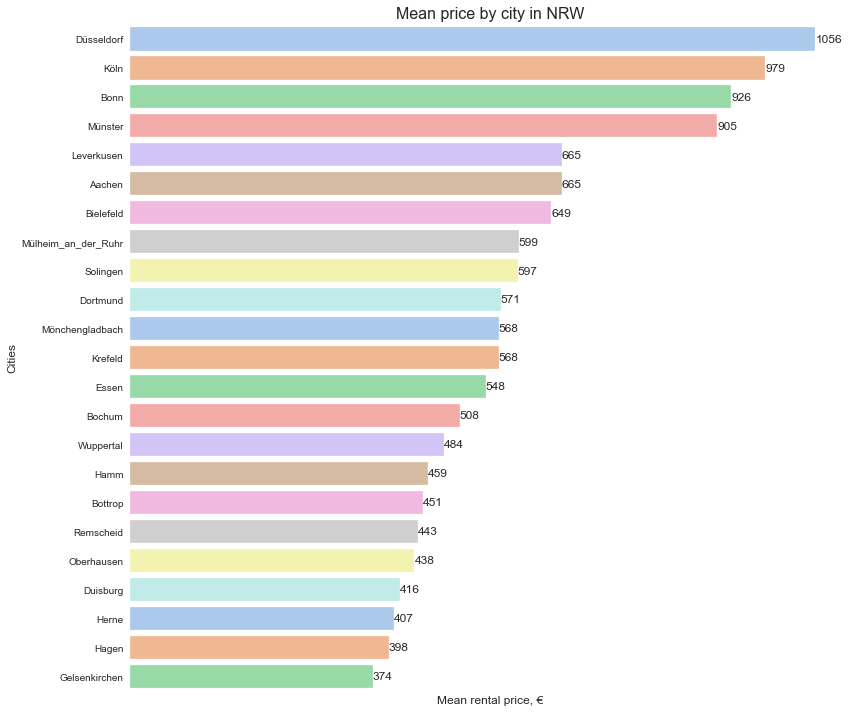

In [10]:
sns.set_style('white')

fig = plt.subplots(figsize=(12, 10))
ax = sns.barplot(x='Kaltmiete',
                 y='Stadt',
                 data=df_pv,
                 orient='h',
                 palette='pastel')

# Setting the annotation on the top of the barchart
n = 0
for land, value in df_pv.iterrows():
    ax.text(x=value[1],  # where to put the text on the x coordinates
            y=n,  # where to put the text on the y coordinates
            s=value[1],  # value to text
            fontsize=12,  # fontsize
            horizontalalignment='left',  # center the text to be more pleasant
            verticalalignment='center')
    n += 1

ax.tick_params(axis='x', labelsize=10, labelbottom=False)
ax.tick_params(axis='y', labelsize=10, bottom='off')
ax.set_title('Mean price by city in NRW', fontsize=16)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)


ax.set_ylabel('Cities', fontsize=12)
ax.set_xlabel('Mean rental price, €', fontsize=12)
plt.tight_layout()

plt.show()

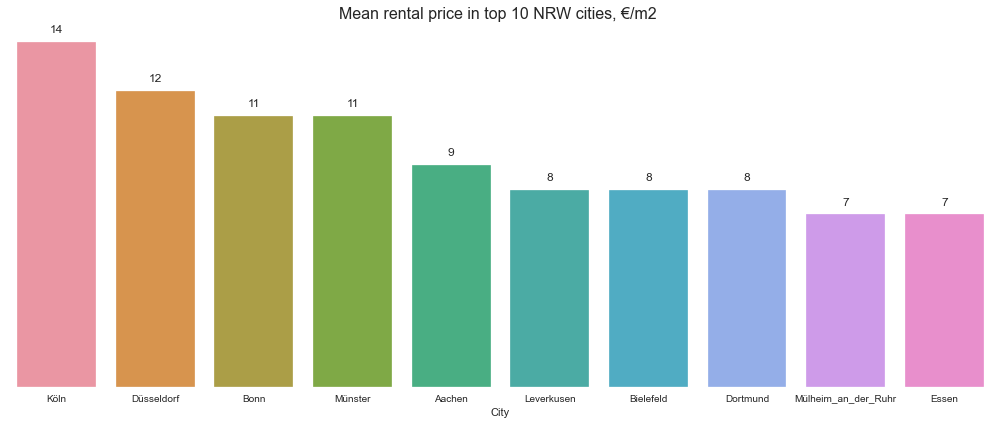

In [11]:
df_pv_m2 = df_city.pivot_table(values='Price_m2', index='Stadt', aggfunc=(np.mean)).reset_index()
df_pv_m2 = df_pv_m2.sort_values(by=['Price_m2'], ascending=False)
df_pv_m2['Price_m2'] = df_pv_m2['Price_m2'].astype(int)

fig = plt.subplots(figsize=(14, 6))
ax = sns.barplot(x='Stadt', y='Price_m2', data=df_pv_m2.head(10), orient='v')

# Setting the annotation on the top of the barchart
n = 0
for land, value in df_pv_m2.head(10).iterrows():
    ax.text(y=value[1] + 0.5,  # where to put the text on the x coordinates
            x=n,  # where to put the text on the y coordinates
            s=value[1],  # value to text
            fontsize=12,  # fontsize
            horizontalalignment='center',  # center the text to be more pleasant
            verticalalignment='center')
    n += 1

ax.tick_params(axis='x', labelsize=10, labelbottom=True)
ax.tick_params(axis='y', labelsize=10, left="off")
ax.set_xlabel('City')
ax.set_title('Mean price by city in NRW', fontsize=16)

ax.tick_params(axis='x', labelsize=10)
ax.set_title('Mean rental price in top 10 NRW cities, €/m2 ', fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.yaxis.set_visible(False)


plt.tight_layout()
plt.show()

In [12]:
df_pv.tail()

,Stadt,Kaltmiete
19,Oberhausen,438
6,Duisburg,416
12,Herne,407
10,Hagen,398
9,Gelsenkirchen,374


As we can see the most expensive cities are Düsseldorf(1056€), Köln(979€), Bonn(926€) and Münster(905€), which are the biggest and the most developed cities in NRW. Bielefeld, Mülheim an der Rurh and Leverkusen are situated in the neighborhood of Köln and Düsseldorf. The lowest prices we can notice in the cities like Gelsenkirchen(374€), an ex-mining city, where after the closing of the last charcoal mine the unemployment rate explode and the demand on the real estate market decrease.  

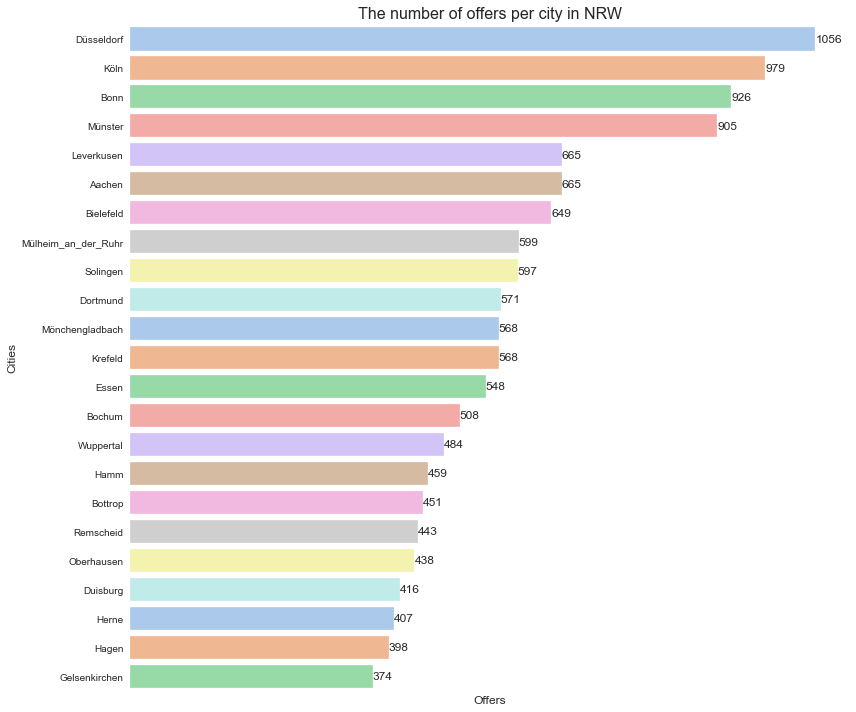

In [13]:
sns.set_style('white')

fig = plt.subplots(figsize=(12, 10))
my_order = df.groupby(by=['Stadt'])['Kaltmiete'].count().sort_values(ascending=False).index
ax = sns.barplot(x='Kaltmiete',
                 y='Stadt',
                 data=df_pv,
                 orient='h',
                 palette='pastel')

# Setting the annotation on the top of the barchart
n = 0
for land, value in df_pv.iterrows():
    ax.text(x=value[1],  # where to put the text on the x coordinates
            y=n,  # where to put the text on the y coordinates
            s=value[1],  # value to text
            fontsize=12,  # fontsize
            horizontalalignment='left',  # center the text to be more pleasant
            verticalalignment='center')
    n += 1


ax.tick_params(axis='x', labelsize=10, labelbottom=False)
ax.tick_params(axis='y', labelsize=10, bottom='off')
ax.set_title('The number of offers per city in NRW', fontsize=16)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)


ax.set_ylabel('Cities', fontsize=12)
ax.set_xlabel('Offers', fontsize=12)
plt.tight_layout()

plt.show()

We can see a big number of offer in the cities like Düsseldorf, Dortmund and Duisburg and it is big because these cities have a big number of suburbs. And we can see also a many offers in the cities like Gelsenkirchen because the real estate offer is bigger than the demand.    

### 2. The real estate market analysis in the city of Köln

Living in Köln give me the opportunity to know the city and to posses some experience on this market. From here I will focus on the data from Köln(Cologne).

In [14]:
# Selecting the values for Cologne
df_koeln = df.loc[df.Stadt == "Köln"].copy()

# Transforming the Kaltmiete column to integer format
df_koeln['Kaltmiete'] = df_koeln['Kaltmiete'].astype(int)

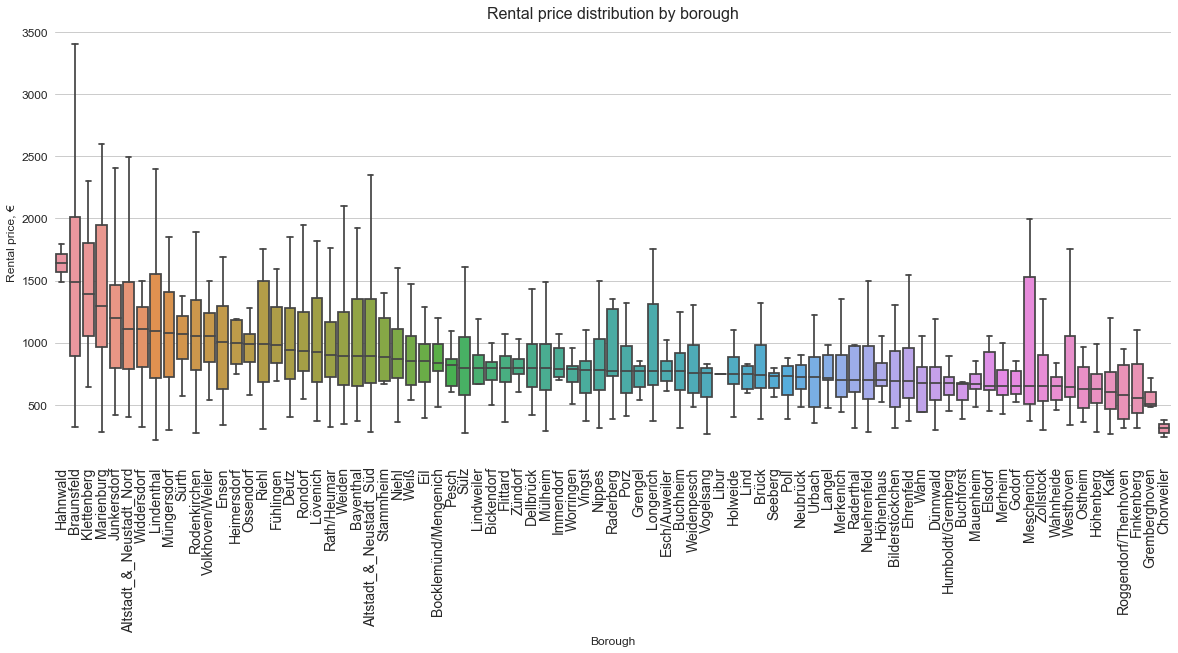

In [15]:
sns.set_style('whitegrid')
fig = plt.subplots(figsize=(20, 8))

my_order = df_koeln.groupby(by=['Stadt_Teil'])['Kaltmiete'].median().sort_values(ascending=False).index
ax = sns.boxplot(x='Stadt_Teil',
                 y='Kaltmiete',
                 data=df_koeln,
                 order=my_order,
                 showfliers=False)

ax.tick_params(axis='x', labelrotation=90, labelsize=14)
ax.tick_params(axis='y', labelsize=12)
ax.set_title('Rental price distribution by borough', fontsize=16)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)

ax.set_xlabel('Borough', fontsize=12)
ax.set_ylabel('Rental price, €', fontsize=12)
plt.show()

As we can see the difference between the highest an the lowest median price is nearly 1000€. It will be better to have a look on the price distribution on the map.

In [16]:
# GeoJson data from the opensource
url = 'https://geoportal.stadt-koeln.de/arcgis/rest/services/Stadtgliederung_15/MapServer/1/query?where=objectid+is+not+null&text=&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&relationParam=&outFields=*&returnGeometry=true&returnTrueCurves=false&maxAllowableOffset=&geometryPrecision=&outSR=4326&returnIdsOnly=false&returnCountOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&gdbVersion=&returnDistinctValues=false&resultOffset=&resultRecordCount=&f=pjson'

In [17]:
# Creating a pivot table with the mean rental price and renaming a column
pv_koeln_m = df_koeln.pivot_table(values='Kaltmiete',
                                  index='Stadt_Teil',
                                  aggfunc=(np.mean)).reset_index()
pv_koeln_m.rename(columns={'Stadt_Teil': 'NAME'}, inplace=True)

In [18]:
# Reading GeoJson in a DataFrame
pik = gpd.read_file(url)

# Reading the data with the Postal Cod for each Köln's borough available on Wikipedia
plz = pd.read_csv("C:/Users/Sinch/Desktop/Real Estate/KOELN_DATA.csv")

# Fixing some data differences and creating a df with boroughs and the mean price per borough
pv_koeln_m.iloc[0, pv_koeln_m.columns.get_loc('NAME')] = 'Altstadt-Süd'
pv_koeln_m.iloc[1, pv_koeln_m.columns.get_loc('NAME')] = 'Altstadt-Nord'
pv_koeln_m.iloc[42, pv_koeln_m.columns.get_loc('NAME')] = "Marienburg (Köln)"

km1 = pv_koeln_m.iloc[0, pv_koeln_m.columns.get_loc('Kaltmiete')]
km2 = pv_koeln_m.iloc[1, pv_koeln_m.columns.get_loc('Kaltmiete')]

nr_1 = pd.DataFrame({'NAME':'Neustadt-Süd', 'Kaltmiete':km1,}, index =[0])
nr_2 = pd.DataFrame({'NAME':'Neustadt-Nord', 'Kaltmiete':km2,}, index =[0])

c_new_df = pd.concat([nr_1, pv_koeln_m]).reset_index(drop = True) 
c_new_df = pd.concat([nr_2, pv_koeln_m]).reset_index(drop = True) 

c_new_df.head()

,NAME,Kaltmiete
0,Neustadt-Nord,1108.557196
1,Altstadt-Süd,1262.144366
2,Altstadt-Nord,1108.557196
3,Bayenthal,1034.290323
4,Bickendorf,841.214286


In [19]:
# Merging data with the borough code with the mean price data
df_concat = pd.merge(left=c_new_df, right=plz, on='NAME', how='outer')

In [20]:
# Fixing some data types problems
df_concat.NUMMER = df_concat.NUMMER.astype(str)

# Merging data with the borough code and mean price with the geographical data
cologne_df = pd.merge(right=df_concat, left=pik, on='NUMMER', how='outer')

# Filling the borough without any information with 0 values
cologne_df.Kaltmiete.fillna(0, inplace=True)

Let's have a look a the map of the Colone city.

<img src=https://upload.wikimedia.org/wikipedia/commons/f/f3/Cologne_subdivisions.svg style='width:600px;height:500px'/>

The city has 9 boroughs: Innenstadt, Rodenkirchen, Lindenthal, Ehrenfeld, Nippes, Chorweiler, Porz, Kalk and Mülheim. The locals called Köln just the city parts that are on the left of the river.  Also there are situated all the sights and green areas of the city. The right part of the city is mostly populated from migrants and students. Let's see if there is a price difference between these two parts. 

In [21]:
# Reading and fixing the geodata
col_cp = gpd.read_file('C:/Users/Sinch/Desktop/Stadtbezirk/Stadtbezirk.shp', dtype={'plz': str})
col_cp.rename(columns={'STB_NR': 'NR_STADTBEZIRK'}, inplace=True)

In [22]:
# There is a backspace in the columns names and it gives us an error
df_concat.columns = df_concat.columns.str.strip()

# Fixing data types
df_con_mean = df_concat.groupby('NR_STADTBEZIRK').mean().reset_index()
df_con_mean.columns = df_con_mean.columns.str.strip()
df_con_mean.NR_STADTBEZIRK = df_con_mean.NR_STADTBEZIRK.astype(str)
col_cp.NR_STADTBEZIRK = col_cp.NR_STADTBEZIRK.astype(str)

In [23]:
# Merging the geaodata for 9 borough and the mean price
col_cp_df = pd.merge(right=df_con_mean,
                     left=col_cp,
                     on='NR_STADTBEZIRK',
                     how='outer')
col_cp_df.Kaltmiete = col_cp_df.Kaltmiete.round().astype(int)

In [24]:
# Setting the borough's names position on the map
cologne_boroughs = {
    'Innenstadt': (2355500, 5644800),
    'Rodenkirchen': (2355000, 5638000),
    'Lindenthal': (2350000, 5644000),
    'Ehrenfeld': (2351000, 5648000),
    'Nippes': (2355000, 5650000),
    'Chorweiler': (2350000, 5655000),
    'Porz': (2365000, 5638000),
    'Kalk': (2361000, 5650000),
    'Mülheim':(2363000, 5644000)
}

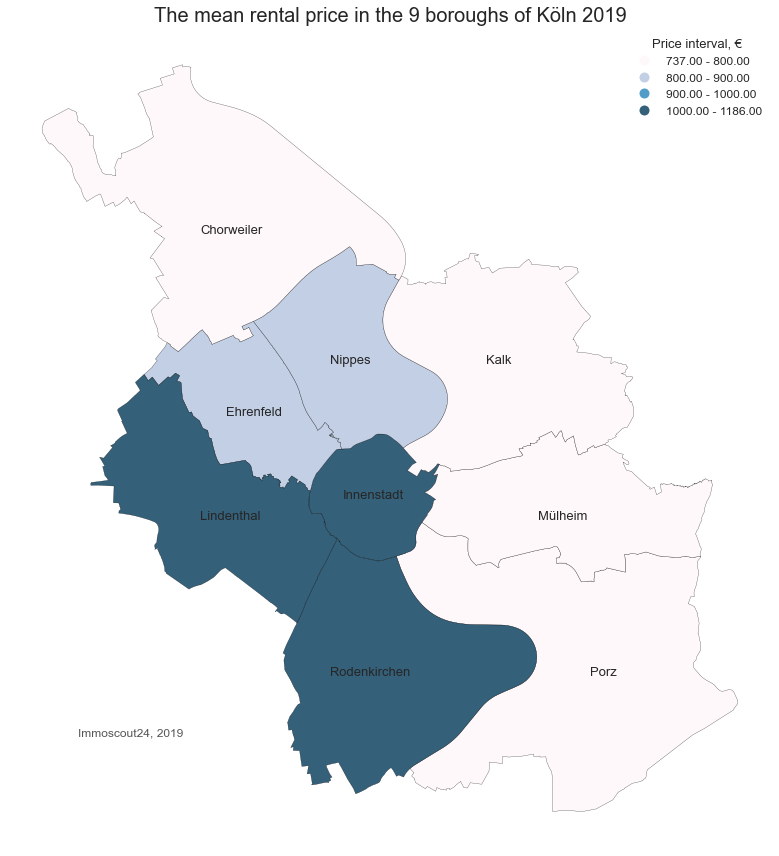

In [25]:
# Plotting
fig, ax = plt.subplots(1, figsize=(12, 12))

col_cp_df.plot(
    ax=ax,
    column='Kaltmiete',
    categorical=False,
    legend=True,
    legend_kwds={'title': 'Price interval, €', 'loc': 'upper right', 'title_fontsize':'13', 'fontsize':'12'},
    scheme="User_Defined",
    classification_kwds={'bins':[800, 900, 1000]},
    cmap='PuBu',
    edgecolor='black',
    alpha=0.8
)

for c in cologne_boroughs.keys():
    ax.text(
        x=cologne_boroughs[c][0], 
        y=cologne_boroughs[c][1], 
        s=c, 
        fontsize=13, 
    )


ax.axis('off')
ax.set_title('The mean rental price in the 9 boroughs of Köln 2019',
             fontdict={'fontsize': '20', 'fontweight' : '3'})

ax.annotate('Immoscout24, 2019', 
            xy=(0.1, 0.15),
            xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=12,
            color='#555555')

plt.tight_layout()
plt.show()

As we can see the right part of the city is cheaper than the left one. The most expensive boroughs are the Inenstadt(Center), Rodenkirchen(a city part where live the rich citizen of Cologne) and Lidenthal(the part where is situated the biggest city park) with the mean price 900-1200€. In the middle are Nippes and Ehrenfeld(parts of the old city with nice old houses and modern offices) with the mean price 800-900€. The cheapest boroughs are situated on the right part of the Rhein, Porz(an industrial part of the city with plants and pollution), Mülheim and Kalk(populated mostly by migrants and students) and Chorweiler(big houses, mixed population, bad connection with the city center) with the mean price between 700-800€.   

Let's have a better look inside each borough.

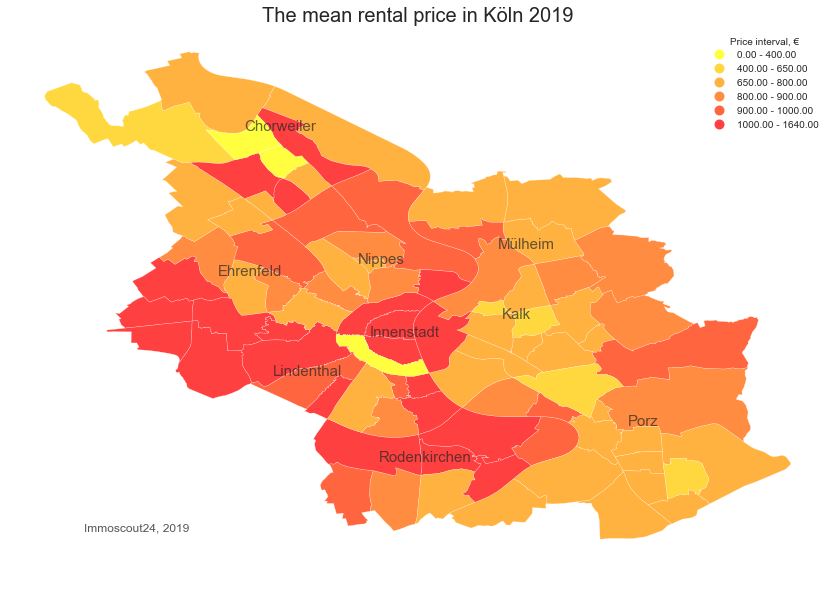

In [26]:
cologne_boroughs = {
    'Innenstadt': (6.960278, 50.936667),
    'Rodenkirchen': (6.971111, 50.871389),
    'Lindenthal': (6.91, 50.916111),
    'Ehrenfeld': (6.88, 50.968389),
    'Nippes': (6.948333, 50.974444),
    'Chorweiler': (6.895639, 51.043778),
    'Porz': (7.085278, 50.89000),
    'Kalk': (7.018611, 50.945833),
    'Mülheim':(7.024167, 50.982222) 
}

#Plotting the data
fig, ax = plt.subplots(1, figsize=(12, 12))

cologne_df.plot(
    ax=ax,
    column='Kaltmiete', 
    categorical=False, 
    legend=True,
    legend_kwds={'title': 'Price interval, €', 'loc': 'upper right'},
    cmap='autumn_r',
    scheme="User_Defined",
    classification_kwds={'bins':[400, 650, 800, 900, 1000]},
    alpha=0.75
)

for c in cologne_boroughs.keys():
    ax.text(
        x=cologne_boroughs[c][0], 
        y=cologne_boroughs[c][1], 
        s=c, 
        fontsize=15,
        ha='center',
        alpha=0.7
    )
    
ax.axis('off')
ax.set_title('The mean rental price in Köln 2019', fontdict={'fontsize': '20', 'fontweight' : '3'})
ax.annotate('Immoscout24, 2019', xy=(0.1, 0.15),  xycoords='figure fraction', horizontalalignment='left',
            verticalalignment='top', fontsize=12, color='#555555')

plt.tight_layout()
plt.show()

As we can see inside each borough the prices are also different, the most expensive streets are situated in the Rodenkirchen and Innenstadt, with the prices between 1000-1640€. In the boroughs like Kakl and Porz it is possible to find a flat even for 400-650€.

### 3.  Factors' analysis

In [27]:
# Pivot table Price vs Room's number
pv_koeln = df_koeln.pivot_table(values='Kaltmiete',
                                index='Zimmer_num',
                                aggfunc=(np.mean))

pv_koeln = pv_koeln.sort_values(by=['Zimmer_num'], ascending=True).round().reset_index()

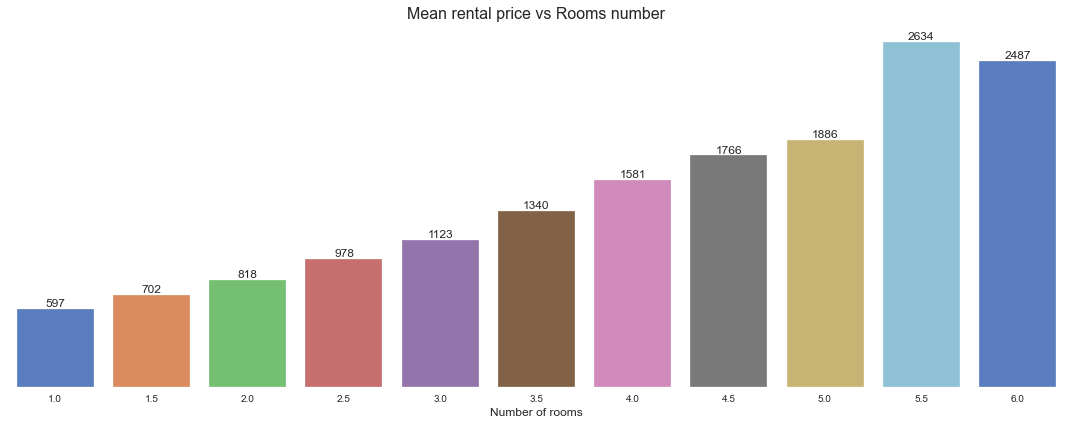

In [28]:
# Plotting
sns.set_style('white')
fig = plt.subplots(figsize=(15, 6))
ax = sns.barplot(x='Zimmer_num', y='Kaltmiete', data=pv_koeln, palette='muted')

# Setting the annotation on the top of the barchart
for zn, value in pv_koeln.iterrows():
    ax.text(x=zn,  # where to put the text on the x coordinates
            y=value[1]+20,  # where to put the text on the y coordinates
            s=int(value[1]),  # value to text
            fontsize=12,  # fontsize
            horizontalalignment='center',  # center the text to be more pleasant
            verticalalignment='baseline')

ax.tick_params(axis='x', labelsize=10)
ax.set_title('Mean rental price vs Rooms number', fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.yaxis.set_visible(False)
ax.set_xlabel('Number of rooms', fontsize=12)

plt.tight_layout()
plt.show()

As we can see the difference between 1 and 2 rooms is nearly 200€, between 2 and 3 is nearly 300€. For each additional room the "bürger"(citizen) of Cologne are ready to pay additional 200-300€. 

In [29]:
# Bining the rental column
bins = [0, 30, 50, 80, 120, np.inf]
names = ['<30', '30-50', '50-80', '80-120', '>120']
df_koeln['Liv_space_cat'] = pd.cut(df_koeln['Living_space'], bins, labels=names)

# Bining the rental column
bins = [0, 1900, 1950, 2000, np.inf]
names = ['<1900', '1900-1950', '1950-2000', '>2000']
df_koeln['Bau_jahr'] = pd.cut(df_koeln['Bau_jahr'], bins, labels=names)

In [30]:
ls_pv = df_koeln.pivot_table(values='Kaltmiete',
                             index='Liv_space_cat',
                             aggfunc=(np.mean)).astype(int).reset_index()

intq_pv = df_koeln.pivot_table(values='Kaltmiete',
                               index='Int_quality',
                               aggfunc=(np.mean)).sort_values(by='Kaltmiete').astype(int).reset_index()

bj_pv = df_koeln.pivot_table(values='Kaltmiete',
                             index='Bau_jahr',
                             aggfunc=(np.mean)).sort_values(by='Bau_jahr').astype(int).reset_index()

wt_pv = df_koeln.pivot_table(values='Kaltmiete',
                             index='Wohnungstyp',
                             aggfunc=(np.mean)).sort_values(by='Kaltmiete').astype(int).reset_index()

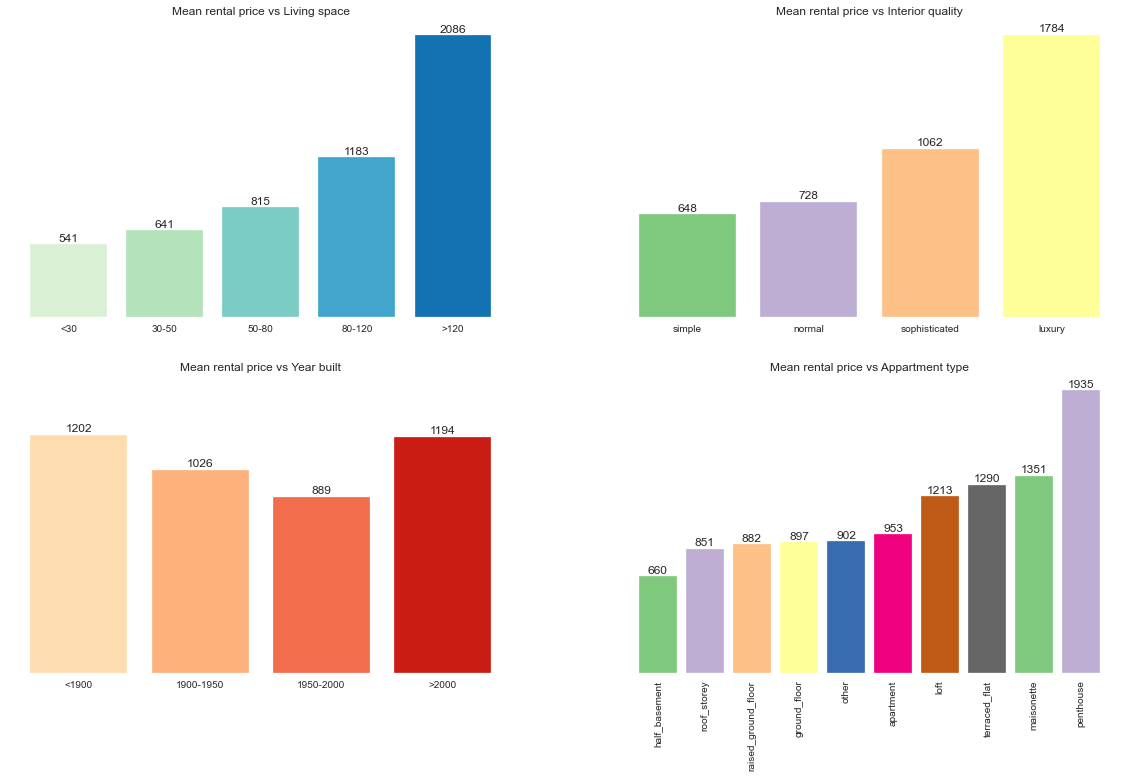

In [31]:
# Plotting
fig = plt.figure(figsize=(20, 12))

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

ax1.bar(ls_pv['Liv_space_cat'], ls_pv['Kaltmiete'], color=sns.color_palette('GnBu', 5))
ax2.bar(intq_pv['Int_quality'], intq_pv['Kaltmiete'], color=sns.color_palette('Accent', 4))
ax3.bar(bj_pv['Bau_jahr'], bj_pv['Kaltmiete'], color=sns.color_palette('OrRd', 4))
ax4.bar(wt_pv['Wohnungstyp'], wt_pv['Kaltmiete'], color=sns.color_palette('Accent', 10))

# Setting the annotation on the top of the barchart
for zn, value in ls_pv.iterrows():
    ax1.text(x=zn,  # where to put the text on the x coordinates
            y=value[1]+20,  # where to put the text on the y coordinates
            s=int(value[1]),  # value to text
            fontsize=12,  # fontsize
            horizontalalignment='center',  # center the text to be more pleasant
            verticalalignment='baseline')

for zn, value in intq_pv.iterrows():
    ax2.text(x=zn,
             y=value[1]+20,
             s=int(value[1]),
             fontsize=12,
             horizontalalignment='center',
             verticalalignment='baseline')

for zn, value in bj_pv.iterrows():
    ax3.text(x=zn,
             y=value[1]+20,
             s=int(value[1]),
             fontsize=12,
             horizontalalignment='center',
             verticalalignment='baseline')

for zn, value in wt_pv.iterrows():
    ax4.text(x=zn,
             y=value[1]+20,
             s=int(value[1]),
             fontsize=12,
             horizontalalignment='center',
             verticalalignment='baseline')

ax1.set_title('Mean rental price vs Living space', fontsize=12)
ax2.set_title('Mean rental price vs Interior quality', fontsize=12)
ax3.set_title('Mean rental price vs Year built', fontsize=12)
ax4.set_title('Mean rental price vs Appartment type', fontsize=12)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.yaxis.set_visible(False)

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.yaxis.set_visible(False)

ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['bottom'].set_visible(True)
ax3.yaxis.set_visible(False)
ax3.set_ylim(0,1500)

ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax4.spines['bottom'].set_visible(True)
ax4.yaxis.set_visible(False)
ax4.tick_params(axis='x', labelrotation=90, labelsize=10)

plt.show()

There is a clear relationship between the Leaving space and the mean price, but however these difference seems to be significant for the flats with living spaces bigger than 50 m2. 

The Interior quality also influence the mean price, there is no big difference in the price between "simple" and "normal" quality so I think these two types can be combined in one group. The difference between "normal", "sophisticated" and luxury is significant 300€ and 700€.

The Year built also influence the rental price, the most expensive flats are situated in the old buildings that are more that 120 years old, mostly they are protected from the city as monuments and the look very "German" the most of them are situated in the city center. The building that are younger that 20 years are also expensive, these is related with the low maintenance costs in comparison with the buildings with an old infrastructure.  

In [32]:
# Factors' pivot tables
bk_pv = df_koeln.pivot_table(values='Kaltmiete', index='Balkon', aggfunc=(np.mean)).astype(int).reset_index()
ek_pv = df_koeln.pivot_table(values='Kaltmiete', index='Einbauküche', aggfunc=(np.mean)).astype(int).reset_index()
kl_pv = df_koeln.pivot_table(values='Kaltmiete', index='Keller', aggfunc=(np.mean)).astype(int).reset_index()
gt_pv = df_koeln.pivot_table(values='Kaltmiete', index='Garten', aggfunc=(np.mean)).astype(int).reset_index()

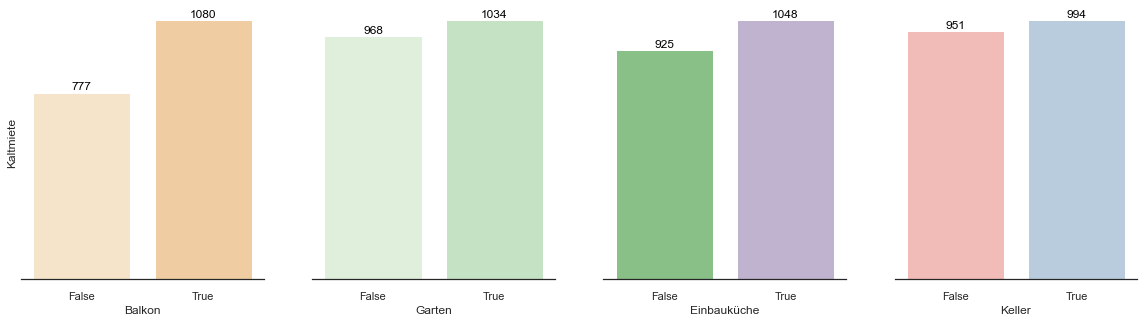

In [33]:
# Set up the matplotlib figure and plotting
sns.set(style='white', palette='muted', color_codes=True)

f, axes = plt.subplots(1, 4, figsize=(20, 5), sharex=False, sharey=False)
sns.despine(left=True)

ax1 = sns.barplot(x='Balkon', y='Kaltmiete', data=bk_pv, ax=axes[0], palette=sns.color_palette('OrRd'))
ax2 = sns.barplot(x='Garten', y='Kaltmiete', data=gt_pv, ax=axes[1], palette=sns.color_palette('GnBu'))
ax3 = sns.barplot(x='Einbauküche', y='Kaltmiete', data=ek_pv, ax=axes[2], palette=sns.color_palette('Accent'))
ax4 = sns.barplot(x='Keller', y='Kaltmiete', data=kl_pv, ax=axes[3], palette=sns.color_palette('Pastel1'))


def annotate(df, ax):
    for index, row in df.iterrows():
        ax.text(row[0], row[1]+10, row.Kaltmiete, color='black', ha='center')


annotate(bk_pv, ax1)
annotate(gt_pv, ax2)
annotate(ek_pv, ax3)
annotate(kl_pv, ax4)

ax1.set(yticks=[])
ax2.set(yticks=[])
ax3.set(yticks=[])
ax4.set(yticks=[])

ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')

plt.show()

As far as we can trust the data, the presence of a balcony or a garden will significantly influence the price, it seems that it is a luxury to this kind of facilities. The price changes also if in there is a kitchen or not, the cheapest kitchen that you can buy in Cologne costs 500-1500€ depending on the size, also for a student there is no reason to rent an apartment without furniture, for this reason the demand on furnished flats is higher. Cologne is a relative safe city and the people left their bicycles outside, it may be a reason for the insignificant difference between flats with and without a cellar.

**In this project we have analyzed the german real estate rental market with the focus on the local market of the Köln city  , based on the information parsed from the website Immoscout24. We have analyzed the rental prices' range, the main factors of that are determining the mean rental price and the influence of the location on the mean rental price.**